# Import the necessary libraries

In [1]:
# Importing the required libraries
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential,Model
from keras.layers import Dense,Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import *

# Load the dataset

In [2]:
df=pd.read_csv('/kaggle/input/isear-dataset/eng_dataset.csv')
df.head()

,ID,sentiment,content
0,10941,anger,At the point today where if someone says somet...
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...
2,10943,anger,This game has pissed me off more than any othe...
3,10944,anger,@spamvicious I've just found out it's Candice ...
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...


In [3]:
Sentences = df['content']
Sentiments = df['sentiment']

In [4]:
len(Sentences), len(Sentiments)

(7102, 7102)

# Load the Glove Embedding

In [5]:
glove ='/kaggle/input/glove6b50dtxt/glove.6B.50d.txt'

def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

Glove = load_glove_embeddings(glove)

In [6]:
def cosine_similarity(a, b):
    """
    Computes the cosine similarity between two vectors a and b.
    """
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

Gunjan = Glove['gunjan']
Pawan = Glove['pawan']
Kumar = Glove['kumar']

cosine_similarity(Pawan, Gunjan)

0.3813103

# Preprocessing

In [7]:
def preprocess(Sentences):
    sentences = tf.strings.substr(Sentences, 0, 300)
    sentences = tf.strings.regex_replace(sentences, b"<br\\s*/?>", b" ")
    sentences = tf.strings.regex_replace(sentences, b"[^a-zA-Z']", b" ")
    sentences = tf.strings.split(sentences)
    sentences = tf.strings.lower(sentences)
    sentences = sentences.to_tensor(default_value=b"<pad>")
    return sentences

In [8]:
sentences = preprocess(Sentences)
sentences.shape

TensorShape([7102, 34])

# Encoding

In [9]:
def encoding(sentences, Glove):
    Encoded_vec = []
    for sentence in sentences:
        sent_vec = []
        for token in sentence:
            token = token.numpy().decode('utf-8')
            if token in Glove:
                sent_vec.append(Glove[token])
            else:
                sent_vec.append(np.zeros(50))
        Encoded_vec.append(sent_vec)
    return Encoded_vec

In [10]:
Encoded_vec = encoding(sentences, Glove)
X = np.array(Encoded_vec)
print(X.shape)

(7102, 34, 50)


# One-hot Encoding of target sentiments

In [11]:
# Perform one-hot encoding on df[0] i.e emotion
enc = OneHotEncoder(handle_unknown='ignore')
Y = enc.fit_transform(np.array(Sentiments).reshape(-1,1)).toarray()
print(Y.shape)

(7102, 4)


# Split the train & test dataset

In [12]:
# Split into train and test
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=23)

In [13]:
#Defining the BiLSTM Model
class BiLSTMModel:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(100, input_shape=(100, 50))))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(4, activation='softmax'))
        self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def fit(self, X, Y, epochs, batch_size):
        self.model.fit(X, Y, epochs=epochs, batch_size=batch_size)

    def evaluate(self, X, Y, batch_size):
        return self.model.evaluate(X, Y, batch_size=batch_size)

    def predict(self, X):
        return self.model.predict(X)

# Train the model

In [14]:
# create an instance of the BiLSTMModel class
model = BiLSTMModel()

# fit the model on the input and target data
model.fit(X_train,Y_train, epochs=20, batch_size=64)

Epoch 1/20
89/89 [==============================] - 11s 9ms/step - loss: 1.2920 - accuracy: 0.3871
Epoch 2/20
89/89 [==============================] - 1s 9ms/step - loss: 1.1199 - accuracy: 0.5112
Epoch 3/20
89/89 [==============================] - 1s 8ms/step - loss: 1.0133 - accuracy: 0.5786
Epoch 4/20
89/89 [==============================] - 1s 10ms/step - loss: 0.9267 - accuracy: 0.6127
Epoch 5/20
89/89 [==============================] - 1s 8ms/step - loss: 0.8516 - accuracy: 0.6522
Epoch 6/20
89/89 [==============================] - 1s 8ms/step - loss: 0.7677 - accuracy: 0.6969
Epoch 7/20
89/89 [==============================] - 1s 8ms/step - loss: 0.6857 - accuracy: 0.7370
Epoch 8/20
89/89 [==============================] - 1s 8ms/step - loss: 0.6214 - accuracy: 0.7585
Epoch 9/20
89/89 [==============================] - 1s 8ms/step - loss: 0.5764 - accuracy: 0.7761
Epoch 10/20
89/89 [==============================] - 1s 8ms/step - loss: 0.5139 - accuracy: 0.8034
Epoch 11/20
89/89

In [15]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 4)                 804       
                                                                 
Total params: 121,604
Trainable params: 121,604
Non-trainable params: 0
_________________________________________________________________


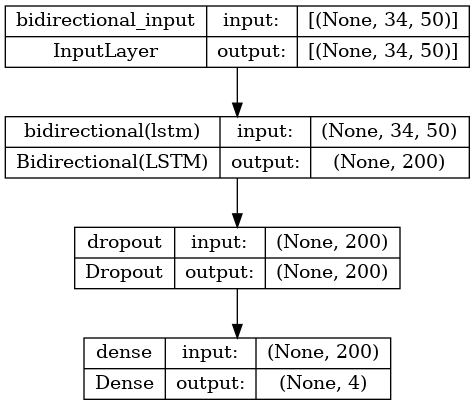

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Evaluations

In [17]:
Loss, acc = model.evaluate(X_test, Y_test, batch_size=64)
print("Loss: %.2f" % (Loss))
print("acc: %.2f" % (acc))

23/23 [==============================] - 1s 6ms/step - loss: 0.7736 - accuracy: 0.7614
Loss: 0.77
acc: 0.76


# Prediction

In [18]:
#First, initialize it.
twt = ['Nothing is more relentless than a dog begging for food']
#Next, tokenize it.
Twt = preprocess(twt)

# Encoding
Twt = encoding(Twt, Glove)
Twt = np.array(Twt)
print(Twt.shape)
#Predict the sentiment by passing the sentence to the model we built.
sentiment = model.predict(Twt)[0]
label = np.argmax(sentiment)
enc.categories_[0][label]

(1, 10, 50)
1/1 [==============================] - 1s 1s/step


'anger'